In [1]:
import sys
import torch
from torch import nn
sys.path.insert(0, '../../')
from lib import dlm

In [3]:
class BiRNNScratch(dlm.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.f_rnn = dlm.RNNScratch(num_inputs, num_hiddens, sigma)
        self.b_rnn = dlm.RNNScratch(num_inputs, num_hiddens, sigma)
        self.num_hiddens *= 2

In [8]:
@dlm.add_to_class(BiRNNScratch)
def forward(self, inputs, Hs=None):
    f_H, b_H = Hs if Hs is not None else (None, None)
    f_outputs, f_H = self.f_rnn(inputs, f_H)
    b_outputs, b_H = self.b_rnn(reversed(inputs), b_H)
    outputs = [torch.cat((f, b), -1) for f, b in zip(f_outputs, b_outputs)] 
    return outputs, (f_H, b_H)

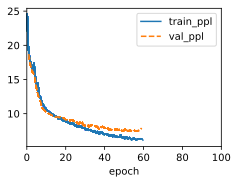

In [ ]:
data = dlm.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = BiRNNScratch(num_inputs=len(data.vocab),
                             num_hiddens=32)
model = dlm.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = dlm.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab, dlm.try_gpu())